This notebook performs training and scoring of Dilated Convolutional Neural Network (CNN) model with visualizations of forecasting results.

In [1]:
import os
import sys
import time
import math
import keras
import random
import datetime
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import optimizers
from keras.layers import * 
from keras.models import Model, load_model
from keras.utils import multi_gpu_model
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
# Append TSPerf path to sys.path
nb_dir = os.path.split(os.getcwd())[0]
tsperf_dir = os.path.dirname(os.path.dirname(os.path.dirname(nb_dir)))
if tsperf_dir not in sys.path:
    sys.path.append(tsperf_dir)

import retail_sales.OrangeJuice_Pt_3Weeks_Weekly.common.benchmark_settings as bs

In [3]:
# Data paths
DATA_DIR = '../../data'
SUBMISSION_DIR = '.'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Data parameters
MAX_STORE_ID = 137
MAX_BRAND_ID = 11

# Parameters of the model 
PRED_HORIZON = 3
PRED_STEPS = 2
SEQ_LEN = 15 
DROPOUT_RATE = 0.01
DYNAMIC_FEATURES = ['deal', 'feat', 'month', 'week_of_month', 'price', 'price_ratio'] 
STATIC_FEATURES = ['store', 'brand']

# Parameters of training algorithm
BATCH_SIZE = 64
LEARNING_RATE = 0.015
EPOCHS = 25

In [4]:
# Utility functions
def week_of_month(dt):
    """Get the week of the month for the specified date.
    
    Args: 
        dt (Datetime): Input date
        
    Returns:
        wom (Integer): Week of the month of the input date
    """ 
    from math import ceil
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    wom = int(ceil(adjusted_dom/7.0))
    return wom

def df_from_cartesian_product(dict_in):
    """Generate a Pandas dataframe from Cartesian product of lists.
    
    Args: 
        dict_in (Dictionary): Dictionary containing multiple lists
        
    Returns:
        df (Dataframe): Dataframe corresponding to the Caresian product of the lists
    """
    from collections import OrderedDict
    from itertools import product
    od = OrderedDict(sorted(dict_in.items()))
    cart = list(product(*od.values()))
    df = pd.DataFrame(cart, columns=od.keys())
    return df

def gen_sequence(df, seq_len, seq_cols, start_timestep=0, end_timestep=None):
    """Reshape features into an array of dimension (time steps, features).  
    
    Args:
        df (Dataframe): Time series data of a specific (store, brand) combination
        seq_len (Integer): The number of previous time series values to use as input features
        seq_cols (List): A list of names of the feature columns 
        start_timestep (Integer): First time step you can use to create feature sequences
        end_timestep (Integer): Last time step you can use to create feature sequences
        
    Returns:
        A generator object for iterating all the feature sequences
    """
    data_array = df[seq_cols].values
    if end_timestep is None:
        end_timestep = df.shape[0]
    for start, stop in zip(range(start_timestep, end_timestep-seq_len+2), range(start_timestep+seq_len, end_timestep+2)):
        yield data_array[start:stop, :]

def gen_sequence_array(df_all, seq_len, seq_cols, start_timestep=0, end_timestep=None):
    """Combine feature sequences for all the combinations of (store, brand) into an 3d array.
    
    Args:
        df_all (Dataframe): Time series data of all stores and brands
        seq_len (Integer): The number of previous time series values to use as input features
        seq_cols (List): A list of names of the feature columns 
        start_timestep (Integer): First time step you can use to create feature sequences
        end_timestep (Integer): Last time step you can use to create feature sequences
        
    Returns:
        seq_array (Numpy Array): An array of the feature sequences of all stores and brands    
    """
    seq_gen = (list(gen_sequence(df_all[(df_all['store']==cur_store) & (df_all['brand']==cur_brand)], \
                                 seq_len, seq_cols, start_timestep, end_timestep)) \
              for cur_store, cur_brand in itertools.product(df_all['store'].unique(), df_all['brand'].unique()))
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    return seq_array

def static_feature_array(df_all, total_timesteps, seq_cols):
    """Generate an arary which encodes all the static features.
    
    Args:
        df_all (Dataframe): Time series data of all stores and brands
        total_timesteps (Integer): Total number of training samples for each store and brand
        seq_cols (List): A list of names of the static feature columns (e.g., store index)
        
    Return:
        fea_array (Numpy Array): An array of static features of all stores and brands
    """
    fea_df = data_filled.groupby(['store', 'brand']). \
                         apply(lambda x: x.iloc[:total_timesteps,:]). \
                         reset_index(drop=True)
    fea_array = fea_df[seq_cols].values
    return fea_array

def normalize_dataframe(df, seq_cols, scaler=MinMaxScaler()):
    """Normalize a subset of columns of a dataframe.
    
    Args:
        df (Dataframe): Input dataframe 
        seq_cols (List): A list of names of columns to be normalized
        scaler (Scaler): A scikit learn scaler object
    
    Returns:
        df_scaled (Dataframe): Normalized dataframe
    """
    cols_fixed = df.columns.difference(seq_cols)
    df_scaled = pd.DataFrame(scaler.fit_transform(df[seq_cols]), 
                            columns=seq_cols, index=df.index)
    df_scaled = pd.concat([df[cols_fixed], df_scaled], axis=1)
    return df_scaled, scaler

def plot_result(results, store, brand):
    """Plot out prediction results and actual sales.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
        store (integer): store index
        brand (integer): brand index
        
    Returns:
        None
    """
    subset = results[(results.store==store) & (results.brand==brand)]
    subset = subset[['week', 'prediction', 'actual']].set_index('week')
    plt.figure()
    ax = subset.plot()
    ax.set_ylim(bottom=0)
    ax.legend(labels=['predicted', 'actual'])

In [5]:
# Model definition
def create_dcnn_model(seq_len, kernel_size=2, n_filters=3, n_input_series=1, n_outputs=1):
    """Create a Dilated CNN model.

    Args: 
        seq_len (Integer): Input sequence length
        kernel_size (Integer): Kernel size of each convolutional layer
        n_filters (Integer): Number of filters in each convolutional layer
        n_outputs (Integer): Number of outputs in the last layer

    Returns:
        Keras Model object
    """
    # Sequential input
    seq_in = Input(shape=(seq_len, n_input_series))
    
    # Categorical input
    cat_fea_in = Input(shape=(2,), dtype='uint8')
    store_id = Lambda(lambda x: x[:, 0, None])(cat_fea_in)
    brand_id = Lambda(lambda x: x[:, 1, None])(cat_fea_in)
    store_embed = Embedding(MAX_STORE_ID+1, 7, input_length=1)(store_id)
    brand_embed = Embedding(MAX_BRAND_ID+1, 4, input_length=1)(brand_id)
    
    # Dilated convolutional layers
    c1 = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=1, 
                padding='causal', activation='relu')(seq_in)
    c2 = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=2, 
                padding='causal', activation='relu')(c1)
    c3 = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=4, 
                padding='causal', activation='relu')(c2)
    
    # Skip connections
    c4 = concatenate([c1, c3])
    
    # Output of convolutional layers 
    conv_out = Conv1D(8, 1, activation='relu')(c4)
    conv_out = Dropout(DROPOUT_RATE)(conv_out) 
    conv_out = Flatten()(conv_out)
    
    # Concatenate with categorical features
    x = concatenate([conv_out, Flatten()(store_embed), Flatten()(brand_embed)])
    #x = BatchNormalization()(x)
    #x = Dense(64, activation='relu')(x)
    #x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    #x = Dropout(0.2)(x)
    output = Dense(n_outputs, activation='linear')(x)
    
    # Define model interface, loss function, and optimizer
    model = Model(inputs=[seq_in, cat_fea_in], outputs=output)
    adam = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss='mape', optimizer=adam, metrics=['mape'])
    return model

model = create_dcnn_model(seq_len=SEQ_LEN, n_input_series=1+len(DYNAMIC_FEATURES), n_outputs=PRED_STEPS)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15, 7)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 15, 3)        45          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 15, 3)        21          conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 15, 3)        21          conv1d_2[0][0]                   
__________________________________________________________________________________________________
concatenat

In [6]:
%%time
# Fix random seeds
np.random.seed(4)
random.seed(4)
tf.set_random_seed(4)
# Train models and make predictions
pred_all = []
combined_all = []
metric_all = []
file_name = os.path.join(SUBMISSION_DIR, 'dcnn_model.h5')
for r in range(bs.NUM_ROUNDS):
    print('---- Round ' + str(r+1) + ' ----')
    offset = 0 if r==0 else 40+r*PRED_STEPS 
    # Load training data
    train_df = pd.read_csv(os.path.join(TRAIN_DIR, 'train_round_'+str(r+1)+'.csv'))
    train_df['move'] = train_df['logmove'].apply(lambda x: round(math.exp(x)))
    #print(train_df.head(3))
    #print('')
    train_df = train_df[['store', 'brand', 'week', 'move']]
    
    # Create a dataframe to hold all necessary data
    store_list = train_df['store'].unique()
    brand_list = train_df['brand'].unique()
    week_list = range(bs.TRAIN_START_WEEK+offset, bs.TEST_END_WEEK_LIST[r]+1)
    d = {'store': store_list,
         'brand': brand_list,
         'week': week_list}        
    data_grid = df_from_cartesian_product(d)
    data_filled = pd.merge(data_grid, train_df, how='left', 
                            on=['store', 'brand', 'week'])
    
    # Get future price, deal, and advertisement info
    aux_df = pd.read_csv(os.path.join(TRAIN_DIR, 'aux_round_'+str(r+1)+'.csv'))  
    data_filled = pd.merge(data_filled, aux_df, how='left',  
                            on=['store', 'brand', 'week'])
    #print('Number of missing rows is {}'.format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
    #print('')

    # Create relative price feature
    price_cols = ['price1', 'price2', 'price3', 'price4', 'price5', 'price6', 'price7', 'price8', \
                  'price9', 'price10', 'price11']
    data_filled['price'] = data_filled.apply(lambda x: x.loc['price' + str(int(x.loc['brand']))], axis=1)
    data_filled['avg_price'] = data_filled[price_cols].sum(axis=1).apply(lambda x: x / len(price_cols))
    data_filled['price_ratio'] = data_filled['price'] / data_filled['avg_price']
    data_filled.drop(price_cols, axis=1, inplace=True) 
    
    # Fill missing values
    data_filled = data_filled.groupby(['store', 'brand']). \
                              apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
    #print(data_filled.head(3))
    #print('')
    
    # Create datetime features
    data_filled['week_start'] = data_filled['week'].apply(lambda x: bs.FIRST_WEEK_START + datetime.timedelta(days=(x-1)*7))
    #data_filled['year'] = data_filled['week_start'].apply(lambda x: x.year)
    data_filled['month'] = data_filled['week_start'].apply(lambda x: x.month)
    data_filled['week_of_month'] = data_filled['week_start'].apply(lambda x: week_of_month(x))
    data_filled['day'] = data_filled['week_start'].apply(lambda x: x.day)
    data_filled.drop('week_start', axis=1, inplace=True)  
    
    # Normalize the dataframe of features
    cols_normalize = data_filled.columns.difference(['store','brand','week'])
    data_scaled, min_max_scaler = normalize_dataframe(data_filled, cols_normalize)
    #data_scaled.head()

    # Create sequence array for 'move'
    start_timestep = 0
    end_timestep = bs.TRAIN_END_WEEK_LIST[r]-bs.TRAIN_START_WEEK-PRED_HORIZON
    train_input1 = gen_sequence_array(data_scaled, SEQ_LEN, ['move'], start_timestep, end_timestep-offset)
    #train_input1.shape

    # Create sequence array for other dynamic features
    start_timestep = PRED_HORIZON
    end_timestep = bs.TRAIN_END_WEEK_LIST[r]-bs.TRAIN_START_WEEK
    train_input2 = gen_sequence_array(data_scaled, SEQ_LEN, DYNAMIC_FEATURES, start_timestep, end_timestep-offset)
    #train_input2.shape

    seq_in = np.concatenate((train_input1, train_input2), axis=2)
    #seq_in.shape

    # Create array of static features
    total_timesteps = bs.TRAIN_END_WEEK_LIST[r]-bs.TRAIN_START_WEEK-SEQ_LEN-PRED_HORIZON+2
    cat_fea_in = static_feature_array(data_filled, total_timesteps-offset, STATIC_FEATURES)
    #cat_fea_in.shape

    # Create training output
    start_timestep = SEQ_LEN+PRED_HORIZON-PRED_STEPS
    end_timestep = bs.TRAIN_END_WEEK_LIST[r]-bs.TRAIN_START_WEEK
    train_output = gen_sequence_array(data_filled, PRED_STEPS, ['move'], start_timestep, end_timestep-offset)
    train_output = np.squeeze(train_output)
    #train_output.shape

    # Create and train model
    if r == 0:
        model = create_dcnn_model(seq_len=SEQ_LEN, n_filters=2, n_input_series=1+len(DYNAMIC_FEATURES), n_outputs=PRED_STEPS)
        adam = optimizers.Adam(lr=LEARNING_RATE)
        model.compile(loss='mape', optimizer=adam, metrics=['mape'])
        # Define checkpoint and fit model
        checkpoint = ModelCheckpoint(file_name, monitor='loss', save_best_only=True, mode='min', verbose=1)
        callbacks_list = [checkpoint]
        history = model.fit([seq_in, cat_fea_in], train_output, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=1)
    else:
        model = load_model(file_name)
        checkpoint = ModelCheckpoint(file_name, monitor='loss', save_best_only=True, mode='min', verbose=1)
        callbacks_list = [checkpoint]
        history = model.fit([seq_in, cat_fea_in], train_output, epochs=1, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=1)   
        
    # Get expected test output
    test_df = pd.read_csv(os.path.join(TEST_DIR, 'test_round_'+str(r+1)+'.csv'))
    test_df['actual'] = test_df['logmove'].apply(lambda x: round(math.exp(x)))
    test_df.drop('logmove', axis=1, inplace=True)

    exp_output = data_filled[data_filled.week >= bs.TEST_START_WEEK_LIST[r]].reset_index(drop=True)
    exp_output = exp_output[['store', 'brand', 'week']]
    exp_output = pd.merge(exp_output, test_df, on=['store', 'brand', 'week'], how='left')

    start_timestep = 0
    end_timestep = PRED_STEPS-1
    exp_test_output = gen_sequence_array(exp_output, PRED_STEPS, ['actual'], start_timestep, end_timestep)
    exp_test_output = np.squeeze(exp_test_output)

    # Get inputs for prediction
    start_timestep = bs.TEST_START_WEEK_LIST[r] - bs.TRAIN_START_WEEK - SEQ_LEN - PRED_HORIZON + PRED_STEPS
    end_timestep = bs.TEST_START_WEEK_LIST[r] - bs.TRAIN_START_WEEK + PRED_STEPS - 1 - PRED_HORIZON
    test_input1 = gen_sequence_array(data_scaled, SEQ_LEN, ['move'], start_timestep-offset, end_timestep-offset)

    start_timestep = bs.TEST_END_WEEK_LIST[r] - bs.TRAIN_START_WEEK - SEQ_LEN + 1
    end_timestep = bs.TEST_END_WEEK_LIST[r] - bs.TRAIN_START_WEEK
    test_input2 = gen_sequence_array(data_scaled, SEQ_LEN, DYNAMIC_FEATURES, start_timestep-offset, end_timestep-offset)

    seq_in = np.concatenate((test_input1, test_input2), axis=2)

    total_timesteps = 1
    cat_fea_in = static_feature_array(data_filled, total_timesteps, STATIC_FEATURES)

    # Make prediction
    pred = np.round(model.predict([seq_in, cat_fea_in]))
    
    # Create dataframe for submission
    pred_df = exp_output.sort_values(['store', 'brand', 'week']).\
                         loc[:,['store', 'brand', 'week']].\
                         reset_index(drop=True)
    pred_df['weeks_ahead'] = pred_df['week'] - bs.TRAIN_END_WEEK_LIST[r]
    pred_df['round'] = r+1
    pred_df['prediction'] = np.reshape(pred, (pred.size, 1))
    combined = pd.merge(pred_df, test_df, on=['store', 'brand', 'week'], how='left')

    pred_all.append(pred_df)
    combined_all.append(combined)
    cur_metric = np.nanmean(np.abs(pred-exp_test_output)/exp_test_output)*100
    metric_all.append(cur_metric)
    print('Current MAPE is {}'.format(cur_metric))

---- Round 1 ----
Epoch 1/25
72127/72127 [==============================] - 4s 57us/step - loss: 55.4567 - mean_absolute_percentage_error: 55.4567

Epoch 00001: loss improved from inf to 55.45668, saving model to ./dcnn_model.h5
Epoch 2/25
72127/72127 [==============================] - 4s 51us/step - loss: 46.8550 - mean_absolute_percentage_error: 46.8550

Epoch 00002: loss improved from 55.45668 to 46.85496, saving model to ./dcnn_model.h5
Epoch 3/25
72127/72127 [==============================] - 4s 51us/step - loss: 45.3687 - mean_absolute_percentage_error: 45.3687

Epoch 00003: loss improved from 46.85496 to 45.36870, saving model to ./dcnn_model.h5
Epoch 4/25
72127/72127 [==============================] - 4s 50us/step - loss: 44.1640 - mean_absolute_percentage_error: 44.1640

Epoch 00004: loss improved from 45.36870 to 44.16396, saving model to ./dcnn_model.h5
Epoch 5/25
72127/72127 [==============================] - 4s 50us/step - loss: 42.9390 - mean_absolute_percentage_error: 42

Current MAPE is 38.666412234306335
CPU times: user 7min 23s, sys: 1min 38s, total: 9min 2s
Wall time: 6min 2s


In [7]:
# Check overall MAPE
np.mean(metric_all)

36.909011751413345

In [8]:
# Generate submission
submission = pd.concat(pred_all, axis=0).reset_index(drop=True)
submission = submission[['round', 'store', 'brand', 'week', 'weeks_ahead', 'prediction']]
submission.head(20)

,round,store,brand,week,weeks_ahead,prediction
0,1,2,1,137,2,9461.0
1,1,2,1,138,3,20539.0
2,1,2,2,137,2,8149.0
3,1,2,2,138,3,27419.0
4,1,2,3,137,2,1755.0
5,1,2,3,138,3,1932.0
6,1,2,4,137,2,3233.0
7,1,2,4,138,3,12297.0
8,1,2,5,137,2,15624.0
9,1,2,5,138,3,4227.0


<Figure size 432x288 with 0 Axes>

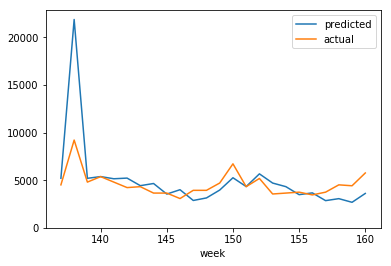

<Figure size 432x288 with 0 Axes>

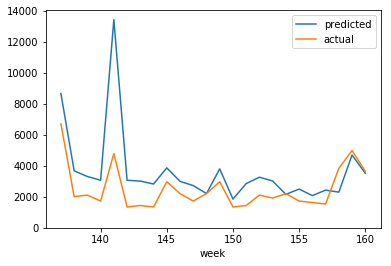

<Figure size 432x288 with 0 Axes>

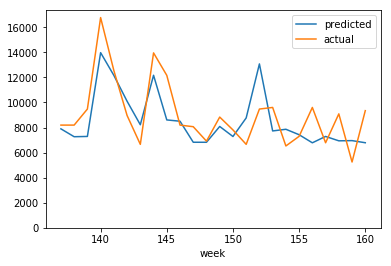

<Figure size 432x288 with 0 Axes>

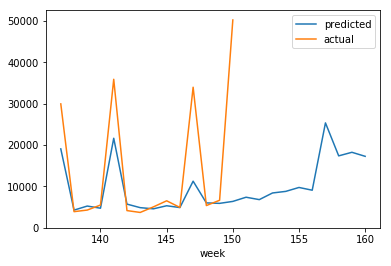

<Figure size 432x288 with 0 Axes>

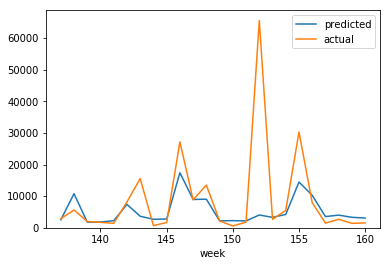

In [9]:
# Visualize forecast results
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(2)

results = pd.concat(combined_all, axis=0)
for _ in range(5):
    store = random.choice(results['store'].unique())
    brand = random.choice(results['brand'].unique())
    plot_result(results, store, brand)